# variant2vec

Learn an emedding of variants annotations (HGVS, BIC etc...), Hugo gene symbols, and classifications (pathogenic, benign...) from the text of pubmed articles.

Goal to see if something like [this](https://www.nature.com/articles/s41586-019-1335-8) paper can be applied to determine characteristics of a variant, or at lease identify the gene associated with the variant from the paper where multiple variants may be mentioned with no canonical gene or transcript qualifier.

In [1]:
import os
import re
import sqlite3
import pandas as pd
import gzip
import glob

crawl_path = "/public/groups/brcaexchange/literature-search/crawl"

## Ingest
Load the text from the pubMunch [pubStore](https://github.com/maximilianh/pubMunch/blob/master/lib/pubStore.py) generated in a BRCA Exchange literature search crawl

In [2]:
connection = sqlite3.connect(f"file:{crawl_path}/text/articles.db?mode=ro", uri=True)
articles = pd.read_sql_query("SELECT * FROM articles", connection)
articles.pmid = articles.pmid.astype(str)
print("{} articles loaded from the articles sqlite database".format(articles.shape[0]))
articles.head()

15079 articles loaded from the articles sqlite database


,articleId,externalId,source,publisher,origFile,journal,printIssn,eIssn,journalUniqueId,year,...,issue,page,pmid,pmcId,doi,fulltextUrl,time,offset,size,chunkId
0,5011585672,PMID11585672,,download,,Trends in genetics : TIG,0168-9525,0168-9525,8507085,2001,...,10,S18,11585672,,10.1016/s0168-9525(01)02451-9,https://linkinghub.elsevier.com/retrieve/pii/S...,2018-11-14T16:29:09+0000,78,5258,0_00000
1,5019688261,PMID19688261,,download,,Breast cancer research and treatment,0167-6806,1573-7217,8111104,2010,...,3,575,19688261,,10.1007/s10549-009-0501-3,,2018-11-14T16:29:16+0000,5048,100825,0_00000
2,5012228710,PMID12228710,,download,,"Science (New York, N.Y.)",0036-8075,1095-9203,0404511,2002,...,5588,1837,12228710,,10.1126/science.297.5588.1837,,2018-11-14T16:29:40+0000,1436851129,148950,0_00000
3,5029369605,PMID29369605,,download,,Genetika,0016-6758,0016-6758,0047354,2016,...,10,1215,29369605,,10.1134/s102279541609012x,https://link.springer.com/article/10.1134%2FS1...,2018-11-14T16:30:43+0000,4458079378,22264,0_00000
4,5022084640,PMID22084640,,download,,Therapeutic advances in medical oncology,1758-8340,1758-8359,101510808,2011,...,6,257,22084640,3210467,10.1177/1758834011417039,,2018-11-14T16:30:58+0000,6079002966,93229,0_00000


In [95]:
%%time
articles = pd.DataFrame()
for path in glob.glob(f"{crawl_path}/text/*.files.gz"):
    articles = articles.append(pd.read_csv(path, sep="\t", encoding="utf-8"))
    
print("{} article text blocks consuming {:.2f} megabytes".format(
    articles.shape[0], articles.memory_usage(index=True).sum() / 2**20))

28938 article text blocks consuming 2.43 megabytes
CPU times: user 28.1 s, sys: 3.32 s, total: 31.4 s
Wall time: 31.4 s


In [96]:
articles.head()

,#fileId,externalId,articleId,url,desc,fileType,time,mimeType,locFname,content
0,5011585672001,PMID11585672,5011585672,https://api.elsevier.com/content/article/pii/S...,supplemental file (.pdf),main.pdf,2018-11-20T17:13:51+0000,application/pdf,/crawl/download/files/11585672.main.pdf,Review|A TRENDS Guide to Mouse Models of H...
1,5019688261001,PMID19688261,5019688261,https://link.springer.com/article/10.1007/s105...,supplemental file (.html),main.html,2018-11-20T17:13:51+0000,text/html,/crawl/download/files/19688261.main.html,Breast Cancer Research and TreatmentJune 201...
2,5019688261002,PMID19688261,5019688261,https://link.springer.com/content/pdf/10.1007%...,supplemental file (.pdf),main.pdf,2018-11-20T17:13:51+0000,application/pdf,/crawl/download/files/19688261.main.pdf,PRECLINICAL STUDYAn integrative genomic and t...
3,5012228710001,PMID12228710,5012228710,http://science.sciencemag.org/content/297/5588...,supplemental file (.html),main.html,2018-11-20T17:13:51+0000,text/html,/crawl/download/files/12228710.main.html,Skip to main contentScience Logo * Home ...
4,5012228710002,PMID12228710,5012228710,http://science.sciencemag.org/content/sci/297/...,supplemental file (.pdf),main.pdf,2018-11-20T17:13:51+0000,application/pdf,/crawl/download/files/12228710.main.pdf,RESEARCH ARTICLESReferences and Notes1. S....


In [212]:
%%time
variants = set()
pattern = re.compile("c\.\d+[atcgATCG]+>[atcgATCG]+")
for article in articles.iloc[0:1000].itertuples():
    variants = variants.union(set(re.findall(pattern, article.content)))
print("Found {} variants".format(len(variants)))

Found 338 variants
CPU times: user 170 ms, sys: 49 ms, total: 219 ms
Wall time: 216 ms


## Clean
https://machinelearningmastery.com/clean-text-machine-learning-python/

In [200]:
!pip3 install --user --upgrade --quiet unidecode
import unidecode

!pip3 install --user --upgrade --quiet nltk
import nltk
import nltk.tokenize
import nltk.stem.porter
# nltk.download("punkt")
nltk.download("stopwords")

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


[nltk_data] Downloading package stopwords to /tf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [205]:
def clean(text):
    # Convert to ascii and replace returns with spaces and lower case
    text = re.sub(r"[\x07]+", ' ', unidecode.unidecode(text)).lower()
    
    # split into words
    words = nltk.tokenize.word_tokenize(text)
    
    # Drop all single character words and stop words - effectively removes punctuation
    words = [w for w in words if len(w) > 1 and w not in stop_words]
    
    # Stem (lowercase's as a side affect as well)
    porter = nltk.stem.porter.PorterStemmer()
    words = [porter.stem(w) for w in words]
    
    return words

print(clean(articles.iloc[42].content))

['cancer', 'breast', 'introduct', 'genet', 'test', 'famili', 'multipl', 'case', 'breast', 'and/or', 'ovarian', 'cancer', 'often', 'target', 'youngest', 'affect', 'woman', 'index', 'case', 'famili', 'clinic', 'genet', 'test', 'context', 'larg', 'limit', 'brca1', 'brca2', 'gene', 'unless', 'addit', 'indic', 'present', 'recent', 'women', 'breast', 'cancer', 'test', 'uninform', 'identifi', 'clearli', 'pathogen', 'mutat', 'either', 'gene.1', 'mani', 'put', 'breast', 'cancer', 'suscept', 'gene', 'identifi', 'vari', 'level', 'evid', 'associ', 'breast', 'cancer', 'today', 'diagnost', 'test', 'facil', 'includ', 'larg', 'number', 'gene', 'singl', 'panel', 'test', 'use', 'massiv', 'parallel', 'next', 'gener', 'sequenc', 'consider', 'reduc', 'cost', 'howev', 'gene', 'panel', 'test', 'pose', 'consider', 'challeng', 'clinic', 'genet', 'servic', 'mani', 'gene', 'valid', 'breast', 'cancer', 'suscept', 'gene', 'even', 'risk', 'associ', 'differ', 'type', 'mutat', 'poorli', 'defined.2', 'test', 'use', 'e

In [215]:
%%time
texts = [clean(article.content) for article in articles.iloc[0:100].itertuples()]

CPU times: user 20.8 s, sys: 41.5 ms, total: 20.8 s
Wall time: 20.8 s


In [217]:
print(articles.iloc[2].content)

PRECLINICAL STUDYAn integrative genomic and transcriptomic analysis revealsmolecular pathways and networks regulated by copy numberaberrations in basal-like, HER2 and luminal cancersRachael Natrajan Æ Britta Weigelt Æ Alan Mackay Æ Felipe C. Geyer ÆAnita Grigoriadis Æ David S. P. Tan Æ Chris Jones Æ Christopher J. Lord ÆRadost Vatcheva Æ Socorro M. Rodriguez-Pinilla Æ Jose Palacios ÆAlan Ashworth Æ Jorge S. Reis-FilhoReceived: 24 July 2009 / Accepted: 28 July 2009 / Published online: 18 August 2009  Springer Science+Business Media, LLC. 2009Abstract Breast cancer is a heterogeneous diseasecaused by the accumulation of genetic changes in neo-plastic cells. We hypothesised that molecular subtypes ofbreast cancer may be driven by specific constellations ofgenes whose expression is regulated by gene copynumber aberrations. To address this question, we ana-lysed a series of 48 microdissected grade III ductalcarcinomas using high resolution microarray comparativegenomic hyb

In [216]:
print(texts[2])

['preclin', 'studi', 'integr', 'genom', 'transcriptom', 'analysi', 'reveal', 'molecular', 'pathway', 'network', 'regul', 'copi', 'number', 'aberr', 'basal-lik', 'her2', 'lumin', 'cancer', 'rachael', 'natrajan', 'ae', 'britta', 'weigelt', 'ae', 'alan', 'mackay', 'ae', 'felip', 'c.', 'geyer', 'ae', 'anita', 'grigoriadi', 'ae', 'david', 's.', 'p.', 'tan', 'ae', 'chri', 'jone', 'ae', 'christoph', 'j.', 'lord', 'ae', 'radost', 'vatcheva', 'ae', 'socorro', 'm.', 'rodriguez-pinilla', 'ae', 'jose', 'palacio', 'ae', 'alan', 'ashworth', 'ae', 'jorg', 's.', 'reis-filho', 'receiv', '24', 'juli', '2009', 'accept', '28', 'juli', '2009', 'publish', 'onlin', '18', 'august', '2009', 'springer', 'science+busi', 'media', 'llc', '2009', 'abstract', 'breast', 'cancer', 'heterogen', 'diseas', 'caus', 'accumul', 'genet', 'chang', 'neo-', 'plastic', 'cell', 'hypothesis', 'molecular', 'subtyp', 'breast', 'cancer', 'may', 'driven', 'specif', 'constel', 'gene', 'whose', 'express', 'regul', 'gene', 'copi', 'numbe

## Train

References:

https://radimrehurek.com/gensim/tut1.html

https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

In [220]:
!pip3 install --user --upgrade --quiet gensim
import gensim
import gensim.models

You should consider upgrading via the 'pip install --upgrade pip' command.


In [229]:
model = gensim.models.Word2Vec(texts)

In [231]:
print(model)
print(model['brca1'])

Word2Vec(vocab=6968, size=100, alpha=0.025)
[-2.4755862e-01 -7.8153157e-01 -8.0560011e-01 -4.8409903e-01
  3.3647668e-01  2.1645081e-01 -3.5262248e-01 -9.0181446e-01
 -3.0526063e-01 -6.3625085e-01  2.7524340e-01 -2.7332041e-02
  2.6516172e-01 -1.0393782e+00  8.1709069e-01 -3.4102071e-02
 -1.1518853e+00  4.8040858e-01  6.9009745e-01 -9.9844307e-01
  1.4020872e+00 -8.2177454e-01  3.6775216e-01  9.1776472e-01
  1.8031593e-02 -8.1322372e-02  1.0435814e+00 -1.0838606e+00
 -3.1519359e-01  1.1972399e+00 -1.1905935e+00 -3.7958217e-01
  1.4032669e+00 -1.2239828e+00 -6.3940579e-01 -5.2143693e-01
  1.1923801e-01 -1.7005415e+00  1.8628597e-01  4.1503182e-01
 -8.2240582e-01  2.2537463e+00  1.1062886e+00  9.3109196e-01
  1.1846621e+00  7.1248150e-01  3.6509210e-01 -4.0508384e-01
 -6.2892437e-01 -1.0977871e+00  6.3394874e-01 -2.2931777e-01
 -5.3467047e-01 -5.2831000e-01  1.3826777e-01  4.5151806e-01
  7.9939818e-01 -3.3114481e-01  1.7573163e-01 -8.7270774e-02
  4.5848361e-01 -5.2088195e-01  4.6835256

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


## Visualize

In [239]:
import sklearn.decomposition
import matplotlib.pyplot as plt

In [240]:
X = model[model.wv.vocab]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [241]:
# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = sklearn.decomposition.PCA(n_components=2)
result = pca.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


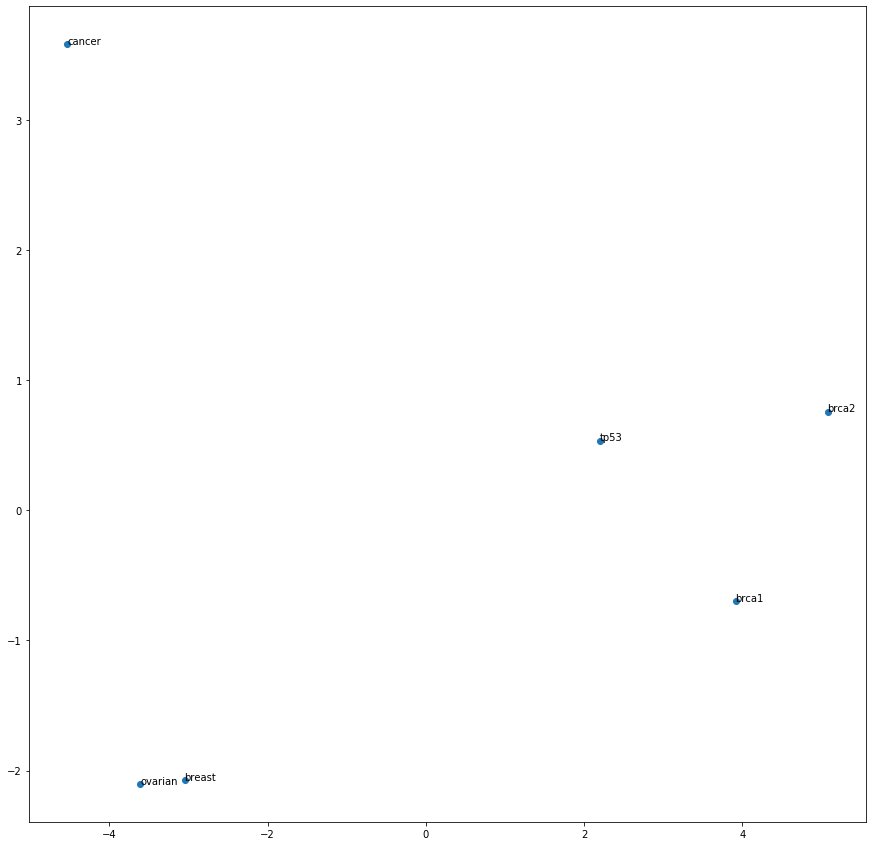

In [261]:
words = list(model.wv.vocab)
targets = ["brca1", "brca2", "tp53", "breast", "cancer", "ovarian"]
indexes = [words.index(w) for w in targets]

pca = sklearn.decomposition.PCA(n_components=2)
result = pca.fit_transform(X[indexes])

# create a scatter plot of the projection
plt.figure(figsize=(15,15))
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)

for i, word in enumerate(targets):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()